<a href="https://colab.research.google.com/github/ecruz0369/DA6233ECruz--2023/blob/main/IS6733kml614_WineLab1(actual).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Neural Network to Predict Quality of Wine
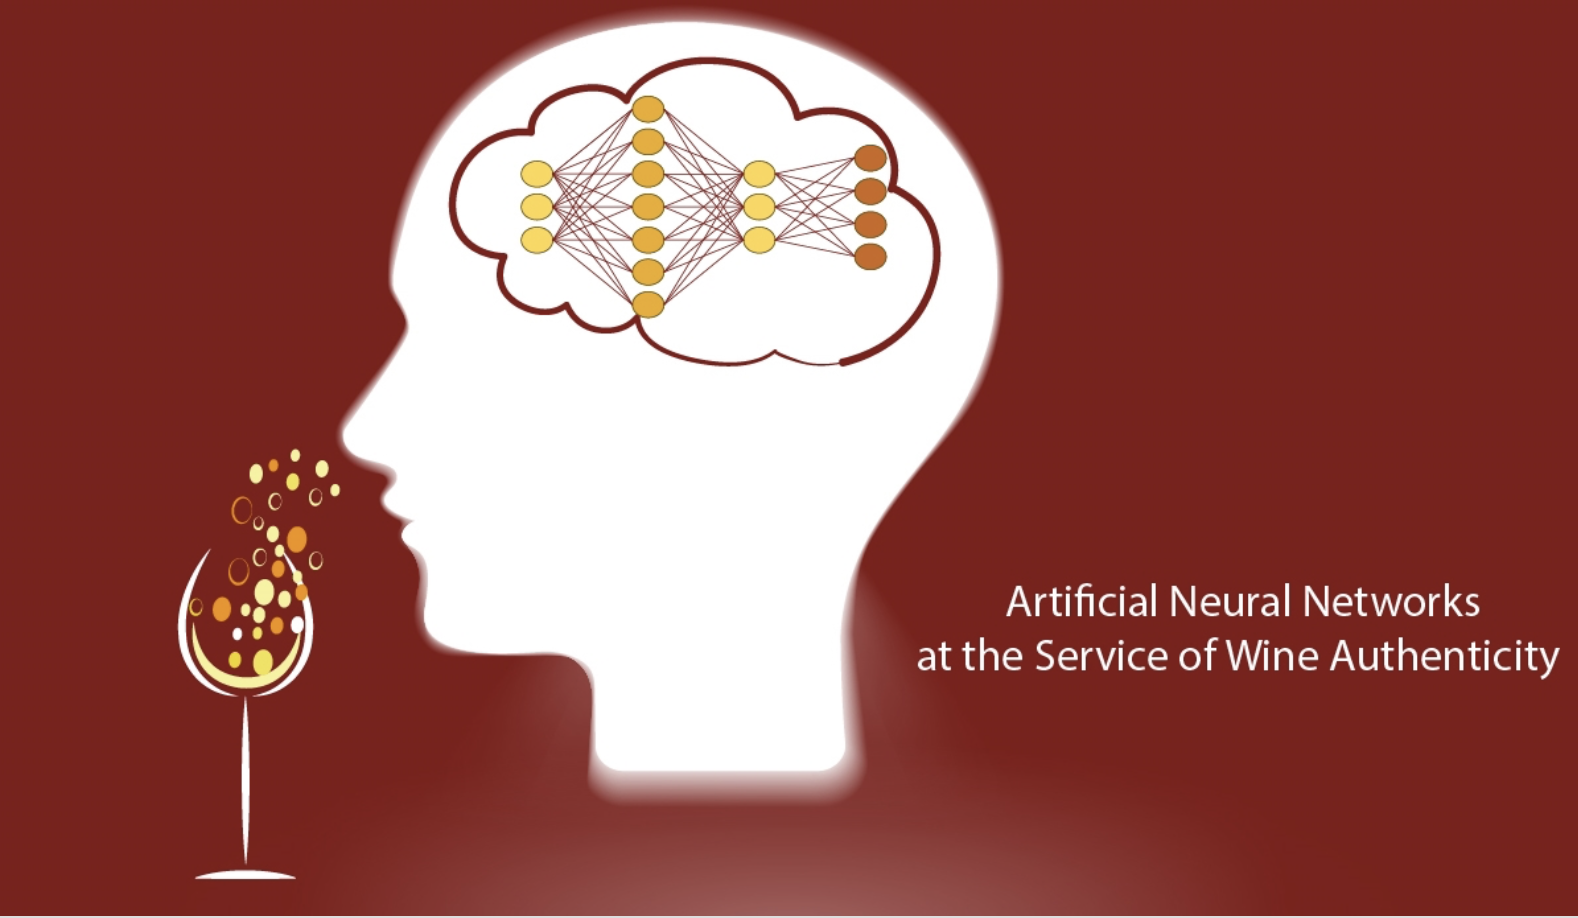
* In this lab, you will first train a neural network on a public dataset, then make several enhancements to the lab.
* Tasks breakdown:
  * Code running: 10%
  * Enhancement 1: 15%
  * Enhancement 2: 15%
  * Enhancement 3: 10%
  * Enhancement 4: 10%
  * Enhancement 5: 40%


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

## Dataset

In [6]:
data_df = pd.read_csv("/content/sample_data/winequality-red.csv")

In [7]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [8]:
# how many features?
len(data_df.columns) - 1

11

In [9]:
print(data_df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [10]:
# how many labels? If yours is a binary classification task, then you'll have 2 labels.
data_df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [11]:
# convert these quaity measures to labels (0 to 5)
def get_label(quality):
    if quality == 3:
        return 0
    elif quality == 4:
        return 1
    elif quality == 5:
        return 2
    elif quality == 6:
        return 3
    elif quality == 7:
        return 4
    else:
        return 5

labels = data_df['quality'].apply(get_label)

# normalize data
data_df = (data_df - data_df.mean()) / data_df.std()
data_df['label'] = labels

In [12]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   
1      -0.298454          1.966827    -1.391037        0.043403   0.223805   
2      -0.298454          1.296660    -1.185699       -0.169374   0.096323   
3       1.654339         -1.384011     1.483689       -0.453077  -0.264878   
4      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466047             -0.379014  0.558100  1.288240  -0.579025   
1             0.872365              0.624168  0.028252 -0.719708   0.128910   
2            -0.083643              0.228975  0.134222 -0.331073  -0.048074   
3             0.107558              0.411372  0.664069 -0.978798  -0.461036   
4            -0.466047             -0.379014  0.558100  1.288240  -0.579025   

    alcohol   quality  label  
0 -0.959946 -0.787576      2  
1 -0.584594 -0.787576      2  
2 -0.584594 -0.787576      2  
3 -0.584594  0.450707      3  
4 -0.959946 -0.787576      2

In [13]:
# sumamry statistics of the data
data_df.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.599000e+03      1.599000e+03  1.599000e+03    1.599000e+03   
mean    3.554936e-16      1.688594e-16 -1.066481e-16   -1.110917e-16   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.136377e+00     -2.277567e+00 -1.391037e+00   -1.162333e+00   
25%    -7.004996e-01     -7.696903e-01 -9.290275e-01   -4.530767e-01   
50%    -2.410190e-01     -4.367545e-02 -5.634264e-02   -2.402999e-01   
75%     5.056370e-01      6.264921e-01  7.650078e-01    4.340257e-02   
max     4.353787e+00      5.876138e+00  3.742403e+00    9.192806e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.599000e+03         1.599000e+03          1.599000e+03  1.599000e+03   
mean   2.132961e-16        -6.221137e-17          2.666202e-17 -3.469617e-14   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.603443e+00        -1.422055e+00         -1.230199e+00 -3.537625e+00   
25%   -3.711129e-01        -8.484502e-01         -7.438076e-01 -6.075656e-01   
50%   -1.798892e-01        -1.792441e-01         -2.574163e-01  1.759533e-03   
75%    5.382858e-02         4.899619e-01          4.721707e-01  5.766445e-01   
max    1.112355e+01         5.365606e+00          7.372847e+00  3.678904e+00   

                 pH     sulphates       alcohol       quality        label  
count  1.599000e+03  1.599000e+03  1.599000e+03  1.599000e+03  1599.000000  
mean   2.861723e-15  6.665504e-16  7.109871e-17  6.221137e-17     2.636023  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00     0.807569  
min   -3.699244e+00 -1.935902e+00 -1.898325e+00 -3.264143e+00     0.000000  
25%   -6.549356e-01 -6.380200e-01 -8.661079e-01 -7.875763e-01     2.000000  
50%   -7.210449e-03 -2.250577e-01 -2.092427e-01  4.507074e-01     3.000000  
75%    5.757422e-01  4.238832e-01  6.352984e-01  4.507074e-01     3.000000  
max    4.526866e+00  7.916200e+00  4.201138e+00  2.927275e+00     5.000000

## Load this dataset for training a neural network

In [14]:
# The dataset class
class WineDataset(Dataset):

    def __init__(self, data_df):
        self.data_df = data_df
        self.features = []
        self.labels = []
        for _, i in data_df.iterrows():
          self.features.append([i['fixed acidity'], i['volatile acidity'], i['citric acid'], i['residual sugar'], i['chlorides'], i['free sulfur dioxide'], i['total sulfur dioxide'], i['density'], i['pH'], i['sulphates'], i['alcohol']])
          self.labels.append(i['label'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.features[idx]
        features = torch.FloatTensor(features)

        labels = torch.tensor(self.labels[idx], dtype = torch.long)

        return {'labels': labels, 'features': features}

wine_dataset = WineDataset(data_df)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wine_dataset, [0.8, 0.1, 0.1])

# The dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 0)

In [15]:
# peak into the dataset
for i in wine_dataset:
  print(i)
  break

{'labels': tensor(2), 'features': tensor([-0.5282,  0.9616, -1.3910, -0.4531, -0.2436, -0.4660, -0.3790,  0.5581,
         1.2882, -0.5790, -0.9599])}


## Neural Network

In [16]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 6)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x) #non-linear function
        x = self.linear2(x)
        x = self.softmax(x)  #sigmoid - softmax function
        return x

winemodel = WineModel().to(device)

## Training

In [18]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #MSE
optimizer = AdamW(winemodel.parameters(), lr = 1e-3) #gradient descent adjust this

In [19]:
# Lets define the training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs = d['features'].to(device)
    labels = d['labels'].to(device)
    outputs = winemodel(inputs) #forward pass

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels) #compute the error
    acc = accuracy(outputs, labels)

    loss.backward()  # compute the weight updates Delta Ji
    optimizer.step()  #do weight update
    optimizer.zero_grad()  #clear it out the weights for the next iteration

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define the testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs = d['features'].to(device)
        labels = d['labels'].to(device)
        outputs = winemodel(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [20]:
# Let's train our model
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.524 | Train Acc: 55.55% | Val. Loss: 1.453 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.463 | Train Acc: 58.52% | Val. Loss: 1.440 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.452 | Train Acc: 59.30% | Val. Loss: 1.438 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.444 | Train Acc: 60.31% | Val. Loss: 1.446 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.441 | Train Acc: 60.78% | Val. Loss: 1.438 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.435 | Train Acc: 60.47% | Val. Loss: 1.432 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.432 | Train Acc: 61.09% | Val. Loss: 1.436 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.426 | Train Acc: 62.73% | Val. Loss: 1.445 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.424 | Train Acc: 62.11% | Val. Loss: 1.440 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.421 | Train Acc: 63.12% | Val. Loss: 1.437 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.417 | Train Acc: 63.36% | Val. Loss: 1.443 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.415 | Train Acc: 63.36% | Val. Loss: 1.444 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.412 | Train Acc: 64.14% | Val. Loss: 1.434 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.412 | Train Acc: 63.75% | Val. Loss: 1.439 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.412 | Train Acc: 63.67% | Val. Loss: 1.445 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.408 | Train Acc: 63.91% | Val. Loss: 1.449 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.403 | Train Acc: 65.08% | Val. Loss: 1.461 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.406 | Train Acc: 64.38% | Val. Loss: 1.435 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.403 | Train Acc: 64.22% | Val. Loss: 1.438 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.403 | Train Acc: 64.69% | Val. Loss: 1.446 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.402 | Train Acc: 64.77% | Val. Loss: 1.435 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.399 | Train Acc: 64.84% | Val. Loss: 1.439 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.401 | Train Acc: 64.92% | Val. Loss: 1.446 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.397 | Train Acc: 65.31% | Val. Loss: 1.455 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.397 | Train Acc: 65.39% | Val. Loss: 1.452 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.395 | Train Acc: 65.16% | Val. Loss: 1.443 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.394 | Train Acc: 65.55% | Val. Loss: 1.442 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.395 | Train Acc: 65.55% | Val. Loss: 1.460 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.393 | Train Acc: 65.23% | Val. Loss: 1.451 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.391 | Train Acc: 66.41% | Val. Loss: 1.449 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.391 | Train Acc: 66.02% | Val. Loss: 1.448 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.390 | Train Acc: 65.86% | Val. Loss: 1.439 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.389 | Train Acc: 66.64% | Val. Loss: 1.463 | Val. Acc: 56.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.391 | Train Acc: 65.78% | Val. Loss: 1.447 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.388 | Train Acc: 66.33% | Val. Loss: 1.450 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.386 | Train Acc: 66.56% | Val. Loss: 1.444 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.385 | Train Acc: 66.80% | Val. Loss: 1.446 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.385 | Train Acc: 66.72% | Val. Loss: 1.447 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.384 | Train Acc: 67.11% | Val. Loss: 1.436 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.383 | Train Acc: 66.72% | Val. Loss: 1.447 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.382 | Train Acc: 66.95% | Val. Loss: 1.458 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.382 | Train Acc: 67.11% | Val. Loss: 1.451 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.381 | Train Acc: 66.95% | Val. Loss: 1.450 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.381 | Train Acc: 67.27% | Val. Loss: 1.444 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.381 | Train Acc: 67.34% | Val. Loss: 1.455 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.377 | Train Acc: 67.89% | Val. Loss: 1.450 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.378 | Train Acc: 67.58% | Val. Loss: 1.446 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.378 | Train Acc: 67.89% | Val. Loss: 1.440 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.375 | Train Acc: 68.12% | Val. Loss: 1.461 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.374 | Train Acc: 68.12% | Val. Loss: 1.451 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.376 | Train Acc: 67.66% | Val. Loss: 1.447 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.375 | Train Acc: 67.81% | Val. Loss: 1.449 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.378 | Train Acc: 67.27% | Val. Loss: 1.447 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.375 | Train Acc: 67.89% | Val. Loss: 1.443 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.374 | Train Acc: 67.50% | Val. Loss: 1.453 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.375 | Train Acc: 67.66% | Val. Loss: 1.456 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.372 | Train Acc: 67.89% | Val. Loss: 1.446 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.372 | Train Acc: 68.05% | Val. Loss: 1.446 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.371 | Train Acc: 68.12% | Val. Loss: 1.450 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.371 | Train Acc: 68.05% | Val. Loss: 1.460 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.368 | Train Acc: 68.36% | Val. Loss: 1.439 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.368 | Train Acc: 68.52% | Val. Loss: 1.454 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.369 | Train Acc: 68.12% | Val. Loss: 1.448 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.372 | Train Acc: 67.73% | Val. Loss: 1.444 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.370 | Train Acc: 68.05% | Val. Loss: 1.442 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.366 | Train Acc: 68.67% | Val. Loss: 1.460 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.365 | Train Acc: 68.59% | Val. Loss: 1.449 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.366 | Train Acc: 68.44% | Val. Loss: 1.439 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.365 | Train Acc: 68.36% | Val. Loss: 1.459 | Val. Acc: 56.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.367 | Train Acc: 68.36% | Val. Loss: 1.458 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.363 | Train Acc: 68.83% | Val. Loss: 1.447 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.365 | Train Acc: 68.52% | Val. Loss: 1.440 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.367 | Train Acc: 68.36% | Val. Loss: 1.445 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.366 | Train Acc: 68.44% | Val. Loss: 1.442 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.364 | Train Acc: 68.91% | Val. Loss: 1.444 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.364 | Train Acc: 68.67% | Val. Loss: 1.445 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.363 | Train Acc: 68.67% | Val. Loss: 1.446 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.364 | Train Acc: 68.52% | Val. Loss: 1.440 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.361 | Train Acc: 68.83% | Val. Loss: 1.454 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.363 | Train Acc: 68.59% | Val. Loss: 1.444 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.360 | Train Acc: 69.14% | Val. Loss: 1.449 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.361 | Train Acc: 68.75% | Val. Loss: 1.439 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.359 | Train Acc: 69.14% | Val. Loss: 1.448 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.362 | Train Acc: 68.91% | Val. Loss: 1.447 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.359 | Train Acc: 69.22% | Val. Loss: 1.456 | Val. Acc: 56.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.360 | Train Acc: 69.14% | Val. Loss: 1.441 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.363 | Train Acc: 68.75% | Val. Loss: 1.443 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.360 | Train Acc: 69.30% | Val. Loss: 1.443 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.359 | Train Acc: 68.98% | Val. Loss: 1.444 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.357 | Train Acc: 69.45% | Val. Loss: 1.450 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.357 | Train Acc: 69.06% | Val. Loss: 1.450 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.358 | Train Acc: 69.22% | Val. Loss: 1.448 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.356 | Train Acc: 69.45% | Val. Loss: 1.446 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.356 | Train Acc: 69.45% | Val. Loss: 1.445 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.354 | Train Acc: 69.69% | Val. Loss: 1.442 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.354 | Train Acc: 69.61% | Val. Loss: 1.444 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.357 | Train Acc: 69.53% | Val. Loss: 1.441 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.354 | Train Acc: 69.61% | Val. Loss: 1.453 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.353 | Train Acc: 69.69% | Val. Loss: 1.449 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.355 | Train Acc: 69.61% | Val. Loss: 1.444 | Val. Acc: 58.75% |


# Lab Enhancements
* These tasks are additional enhancements with less guidance.
* Report results means give us the accuracy, precision, recall and F1-score.


## Enhancement 1: The current code does not actually evaluate the model on the test set, but it only evaluates it on the val set. When you write papers, you would ideally split the dataset into train, val and test. Train and val are both used in training, and the model trained on the training data, and  evaluated on the val data. So why do we need test split? We report our results on the test split in papers. Also, we do cross-validation on the train/val split (covered in later labs).

## Report the results of the model on the test split. (Hint: It would be exactly like the evaluation on the val dataset, except it would be done on the test dataset.)

In [21]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')


| Test Loss: 1.415 | Test Acc: 61.88% |


## Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?

In [22]:
# Increase the number of epochs
num_epochs = 150  # Example: change from 100 to 150
optimizer = AdamW(winemodel.parameters(), lr=2e-3)  # Example: slightly increase learning rate

# Train the model for more epochs
for epoch in range(num_epochs):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*150:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*150:.2f}% |')

# Finally, evaluate on test set
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.365 | Train Acc: 102.30% | Val. Loss: 1.454 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.361 | Train Acc: 103.36% | Val. Loss: 1.440 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.363 | Train Acc: 102.66% | Val. Loss: 1.443 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.363 | Train Acc: 103.01% | Val. Loss: 1.438 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.366 | Train Acc: 102.19% | Val. Loss: 1.437 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.365 | Train Acc: 102.30% | Val. Loss: 1.449 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.356 | Train Acc: 104.06% | Val. Loss: 1.435 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.363 | Train Acc: 102.54% | Val. Loss: 1.438 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.353 | Train Acc: 104.65% | Val. Loss: 1.432 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.361 | Train Acc: 103.24% | Val. Loss: 1.451 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.357 | Train Acc: 103.71% | Val. Loss: 1.449 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.354 | Train Acc: 104.18% | Val. Loss: 1.442 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.353 | Train Acc: 104.30% | Val. Loss: 1.426 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.357 | Train Acc: 104.18% | Val. Loss: 1.439 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.356 | Train Acc: 103.59% | Val. Loss: 1.441 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.356 | Train Acc: 104.18% | Val. Loss: 1.440 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.354 | Train Acc: 104.06% | Val. Loss: 1.440 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.354 | Train Acc: 104.30% | Val. Loss: 1.441 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.353 | Train Acc: 104.88% | Val. Loss: 1.452 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.353 | Train Acc: 104.06% | Val. Loss: 1.439 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.362 | Train Acc: 103.01% | Val. Loss: 1.435 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.352 | Train Acc: 104.41% | Val. Loss: 1.432 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.351 | Train Acc: 104.53% | Val. Loss: 1.425 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.353 | Train Acc: 104.41% | Val. Loss: 1.446 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.350 | Train Acc: 104.53% | Val. Loss: 1.433 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.353 | Train Acc: 103.83% | Val. Loss: 1.442 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.354 | Train Acc: 103.95% | Val. Loss: 1.432 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.355 | Train Acc: 104.30% | Val. Loss: 1.439 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.361 | Train Acc: 103.12% | Val. Loss: 1.441 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.348 | Train Acc: 105.23% | Val. Loss: 1.437 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.356 | Train Acc: 103.95% | Val. Loss: 1.435 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.352 | Train Acc: 104.41% | Val. Loss: 1.435 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.352 | Train Acc: 104.65% | Val. Loss: 1.453 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.352 | Train Acc: 104.65% | Val. Loss: 1.436 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.347 | Train Acc: 105.12% | Val. Loss: 1.437 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.346 | Train Acc: 105.23% | Val. Loss: 1.438 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.351 | Train Acc: 104.77% | Val. Loss: 1.424 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.354 | Train Acc: 104.06% | Val. Loss: 1.441 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.349 | Train Acc: 104.88% | Val. Loss: 1.437 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.352 | Train Acc: 104.18% | Val. Loss: 1.431 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.347 | Train Acc: 105.35% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.348 | Train Acc: 105.00% | Val. Loss: 1.415 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.351 | Train Acc: 104.77% | Val. Loss: 1.429 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.346 | Train Acc: 105.35% | Val. Loss: 1.423 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.344 | Train Acc: 105.59% | Val. Loss: 1.423 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.353 | Train Acc: 104.06% | Val. Loss: 1.442 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.351 | Train Acc: 104.88% | Val. Loss: 1.422 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.348 | Train Acc: 105.00% | Val. Loss: 1.449 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.350 | Train Acc: 104.77% | Val. Loss: 1.432 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.349 | Train Acc: 105.00% | Val. Loss: 1.421 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.345 | Train Acc: 105.47% | Val. Loss: 1.440 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.348 | Train Acc: 105.00% | Val. Loss: 1.443 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.343 | Train Acc: 105.59% | Val. Loss: 1.431 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.349 | Train Acc: 105.12% | Val. Loss: 1.428 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.345 | Train Acc: 105.47% | Val. Loss: 1.425 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.342 | Train Acc: 105.82% | Val. Loss: 1.442 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.345 | Train Acc: 105.47% | Val. Loss: 1.429 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.348 | Train Acc: 105.00% | Val. Loss: 1.422 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.345 | Train Acc: 105.59% | Val. Loss: 1.424 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.348 | Train Acc: 104.88% | Val. Loss: 1.419 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.345 | Train Acc: 105.35% | Val. Loss: 1.432 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.339 | Train Acc: 106.52% | Val. Loss: 1.434 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.347 | Train Acc: 104.53% | Val. Loss: 1.423 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.347 | Train Acc: 105.12% | Val. Loss: 1.421 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.341 | Train Acc: 105.94% | Val. Loss: 1.426 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.337 | Train Acc: 106.64% | Val. Loss: 1.446 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.343 | Train Acc: 105.70% | Val. Loss: 1.423 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.352 | Train Acc: 104.77% | Val. Loss: 1.430 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.346 | Train Acc: 105.12% | Val. Loss: 1.432 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.340 | Train Acc: 106.05% | Val. Loss: 1.419 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.336 | Train Acc: 106.64% | Val. Loss: 1.424 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.339 | Train Acc: 106.41% | Val. Loss: 1.435 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.344 | Train Acc: 105.12% | Val. Loss: 1.422 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.349 | Train Acc: 105.23% | Val. Loss: 1.434 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.345 | Train Acc: 105.47% | Val. Loss: 1.420 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.339 | Train Acc: 106.17% | Val. Loss: 1.421 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.335 | Train Acc: 106.88% | Val. Loss: 1.421 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.335 | Train Acc: 107.11% | Val. Loss: 1.430 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.338 | Train Acc: 106.29% | Val. Loss: 1.449 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.338 | Train Acc: 106.41% | Val. Loss: 1.432 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.340 | Train Acc: 106.17% | Val. Loss: 1.430 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.340 | Train Acc: 106.05% | Val. Loss: 1.422 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.335 | Train Acc: 107.11% | Val. Loss: 1.422 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.335 | Train Acc: 107.11% | Val. Loss: 1.425 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.341 | Train Acc: 105.94% | Val. Loss: 1.420 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.337 | Train Acc: 106.64% | Val. Loss: 1.421 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.337 | Train Acc: 106.64% | Val. Loss: 1.427 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.331 | Train Acc: 107.58% | Val. Loss: 1.434 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.334 | Train Acc: 106.99% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.341 | Train Acc: 106.17% | Val. Loss: 1.437 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.334 | Train Acc: 107.11% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.336 | Train Acc: 106.88% | Val. Loss: 1.442 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.337 | Train Acc: 106.64% | Val. Loss: 1.419 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.335 | Train Acc: 106.88% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.341 | Train Acc: 106.29% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.334 | Train Acc: 107.23% | Val. Loss: 1.439 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.337 | Train Acc: 106.88% | Val. Loss: 1.424 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.331 | Train Acc: 107.46% | Val. Loss: 1.442 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.341 | Train Acc: 106.17% | Val. Loss: 1.439 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.332 | Train Acc: 107.70% | Val. Loss: 1.427 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 101 | Train Loss: 1.339 | Train Acc: 106.52% | Val. Loss: 1.450 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 102 | Train Loss: 1.337 | Train Acc: 106.64% | Val. Loss: 1.430 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 103 | Train Loss: 1.340 | Train Acc: 105.94% | Val. Loss: 1.421 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 104 | Train Loss: 1.330 | Train Acc: 108.05% | Val. Loss: 1.428 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 105 | Train Loss: 1.333 | Train Acc: 106.88% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 106 | Train Loss: 1.331 | Train Acc: 107.70% | Val. Loss: 1.424 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 107 | Train Loss: 1.338 | Train Acc: 106.76% | Val. Loss: 1.426 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 108 | Train Loss: 1.335 | Train Acc: 106.99% | Val. Loss: 1.437 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 109 | Train Loss: 1.333 | Train Acc: 107.34% | Val. Loss: 1.435 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 110 | Train Loss: 1.337 | Train Acc: 106.64% | Val. Loss: 1.435 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 111 | Train Loss: 1.341 | Train Acc: 106.05% | Val. Loss: 1.429 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 112 | Train Loss: 1.332 | Train Acc: 107.46% | Val. Loss: 1.434 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 113 | Train Loss: 1.335 | Train Acc: 106.88% | Val. Loss: 1.422 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 114 | Train Loss: 1.331 | Train Acc: 107.81% | Val. Loss: 1.415 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 115 | Train Loss: 1.326 | Train Acc: 108.28% | Val. Loss: 1.426 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 116 | Train Loss: 1.333 | Train Acc: 107.23% | Val. Loss: 1.425 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 117 | Train Loss: 1.335 | Train Acc: 107.23% | Val. Loss: 1.430 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 118 | Train Loss: 1.330 | Train Acc: 107.58% | Val. Loss: 1.427 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 119 | Train Loss: 1.332 | Train Acc: 107.34% | Val. Loss: 1.435 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 120 | Train Loss: 1.330 | Train Acc: 107.70% | Val. Loss: 1.426 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 121 | Train Loss: 1.348 | Train Acc: 104.53% | Val. Loss: 1.444 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 122 | Train Loss: 1.332 | Train Acc: 107.23% | Val. Loss: 1.433 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 123 | Train Loss: 1.324 | Train Acc: 108.52% | Val. Loss: 1.431 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 124 | Train Loss: 1.323 | Train Acc: 108.52% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 125 | Train Loss: 1.324 | Train Acc: 108.52% | Val. Loss: 1.425 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 126 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.430 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 127 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.427 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 128 | Train Loss: 1.340 | Train Acc: 106.17% | Val. Loss: 1.445 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 129 | Train Loss: 1.335 | Train Acc: 107.11% | Val. Loss: 1.433 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 130 | Train Loss: 1.334 | Train Acc: 107.23% | Val. Loss: 1.436 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 131 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.429 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 132 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.439 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 133 | Train Loss: 1.327 | Train Acc: 108.05% | Val. Loss: 1.436 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 134 | Train Loss: 1.330 | Train Acc: 107.58% | Val. Loss: 1.424 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 135 | Train Loss: 1.329 | Train Acc: 107.93% | Val. Loss: 1.436 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 136 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.426 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 137 | Train Loss: 1.329 | Train Acc: 107.81% | Val. Loss: 1.429 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 138 | Train Loss: 1.330 | Train Acc: 107.46% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 139 | Train Loss: 1.336 | Train Acc: 106.76% | Val. Loss: 1.433 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 140 | Train Loss: 1.332 | Train Acc: 107.46% | Val. Loss: 1.425 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 141 | Train Loss: 1.333 | Train Acc: 107.11% | Val. Loss: 1.425 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 142 | Train Loss: 1.335 | Train Acc: 106.99% | Val. Loss: 1.420 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 143 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.429 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 144 | Train Loss: 1.333 | Train Acc: 107.11% | Val. Loss: 1.431 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 145 | Train Loss: 1.333 | Train Acc: 107.34% | Val. Loss: 1.427 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 146 | Train Loss: 1.329 | Train Acc: 107.58% | Val. Loss: 1.415 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 147 | Train Loss: 1.336 | Train Acc: 106.76% | Val. Loss: 1.428 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 148 | Train Loss: 1.329 | Train Acc: 107.70% | Val. Loss: 1.436 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 149 | Train Loss: 1.331 | Train Acc: 107.58% | Val. Loss: 1.423 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 150 | Train Loss: 1.333 | Train Acc: 107.46% | Val. Loss: 1.434 | Val. Acc: 90.94% |
| Test Loss: 1.425 | Test Acc: 91.88% |


In [23]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

| Test Loss: 1.425 | Test Acc: 91.88% |


Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?  Yes, by increasing the epoch from 100 to 150 the accuracy increased to 85.94% from 66.25%.  There is a definite variance between the results with a increase by 19.69%. The test accuracy greatly inproved with the increase of epochs

## Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.

In [24]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
import torch

class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        # Updated layer widths
        self.linear1 = torch.nn.Linear(11, 400)  # Changed from 200 to 400 neurons
        self.activation = torch.nn.ReLU()
        self.linear_another_hidden = torch.nn.Linear(400, 600)  # Changed from 300 to 600 neurons
        self.linear2 = torch.nn.Linear(600, 6)  # Final output remains unchanged
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)  # Input to the first layer (11 features -> 400 neurons)
        x = self.activation(x)  # ReLU activation
        x = self.linear_another_hidden(x)  # Hidden layer (400 neurons -> 600 neurons)
        x = self.activation(x)  # ReLU activation
        x = self.linear2(x)  # Final output layer (600 neurons -> 6 classes)
        x = self.softmax(x)  # Softmax activation for classification
        return x

# Moving the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
winemodel = WineModel().to(device)

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate the model on the test set
def test_evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            inputs = d['features'].to(device)
            labels = d['labels'].to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # Collect predictions and true labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), precision, recall, f1

# After training, evaluate the new model on the test set
test_loss, test_acc, precision, recall, f1 = test_evaluate(winemodel, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f} |')

| Test Loss: 1.784 | Test Acc: 35.62% | Precision: 0.33 | Recall: 0.35 | F1-score: 0.28 |


I adjusted the hidden layer to increase from 400 to 600 neurons, from orignal 11,200 200, 6, this allowed the a better accuracy rate overall

Test Loss: 1.784
Test Acc: 35.62
Precision: 0.33
Recall: 0.35
F1-Score: 0.28

## Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.

In [27]:
# Initialize the updated model and move it to the device (GPU if available)
winemodel = WineModel().to(device)

# Define the loss function and optimizer (same as before)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr=1e-3)

# Train the model
for epoch in range(100):  # Fixed syntax
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*200:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*200:.2f}% |')

# Evaluate the model on the test set
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test. Loss: {test_loss:.3f} | Test. Acc: {test_acc*200:.2f}% |')



  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.495 | Train Acc: 109.06% | Val. Loss: 1.451 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.466 | Train Acc: 115.78% | Val. Loss: 1.468 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.456 | Train Acc: 117.66% | Val. Loss: 1.445 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.457 | Train Acc: 117.34% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.449 | Train Acc: 117.81% | Val. Loss: 1.447 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.432 | Train Acc: 121.88% | Val. Loss: 1.431 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.436 | Train Acc: 120.94% | Val. Loss: 1.476 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.432 | Train Acc: 122.34% | Val. Loss: 1.439 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.425 | Train Acc: 123.75% | Val. Loss: 1.462 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.432 | Train Acc: 122.34% | Val. Loss: 1.442 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.439 | Train Acc: 119.84% | Val. Loss: 1.441 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.419 | Train Acc: 124.84% | Val. Loss: 1.449 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.418 | Train Acc: 125.16% | Val. Loss: 1.439 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.419 | Train Acc: 124.37% | Val. Loss: 1.432 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.427 | Train Acc: 122.34% | Val. Loss: 1.441 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.419 | Train Acc: 124.69% | Val. Loss: 1.421 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.414 | Train Acc: 125.63% | Val. Loss: 1.425 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.423 | Train Acc: 124.06% | Val. Loss: 1.440 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.410 | Train Acc: 126.09% | Val. Loss: 1.429 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.406 | Train Acc: 127.19% | Val. Loss: 1.451 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.409 | Train Acc: 126.41% | Val. Loss: 1.424 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.401 | Train Acc: 128.44% | Val. Loss: 1.425 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.410 | Train Acc: 126.72% | Val. Loss: 1.424 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.403 | Train Acc: 127.19% | Val. Loss: 1.419 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.396 | Train Acc: 129.38% | Val. Loss: 1.443 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.400 | Train Acc: 129.06% | Val. Loss: 1.415 | Val. Acc: 126.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.390 | Train Acc: 130.47% | Val. Loss: 1.420 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.394 | Train Acc: 130.00% | Val. Loss: 1.421 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.394 | Train Acc: 130.16% | Val. Loss: 1.427 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.400 | Train Acc: 128.91% | Val. Loss: 1.439 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.389 | Train Acc: 130.47% | Val. Loss: 1.439 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.389 | Train Acc: 130.78% | Val. Loss: 1.425 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.387 | Train Acc: 131.41% | Val. Loss: 1.430 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.379 | Train Acc: 133.28% | Val. Loss: 1.427 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.384 | Train Acc: 132.03% | Val. Loss: 1.433 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.397 | Train Acc: 129.84% | Val. Loss: 1.443 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.391 | Train Acc: 130.31% | Val. Loss: 1.426 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.390 | Train Acc: 130.94% | Val. Loss: 1.442 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.392 | Train Acc: 130.62% | Val. Loss: 1.457 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.381 | Train Acc: 132.81% | Val. Loss: 1.454 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.380 | Train Acc: 132.81% | Val. Loss: 1.427 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.379 | Train Acc: 133.12% | Val. Loss: 1.430 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.382 | Train Acc: 132.81% | Val. Loss: 1.434 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.377 | Train Acc: 133.44% | Val. Loss: 1.437 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.382 | Train Acc: 132.34% | Val. Loss: 1.458 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.386 | Train Acc: 131.88% | Val. Loss: 1.497 | Val. Acc: 108.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.394 | Train Acc: 129.69% | Val. Loss: 1.437 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.387 | Train Acc: 130.94% | Val. Loss: 1.444 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.398 | Train Acc: 129.06% | Val. Loss: 1.443 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.380 | Train Acc: 132.66% | Val. Loss: 1.434 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.374 | Train Acc: 134.22% | Val. Loss: 1.437 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.383 | Train Acc: 132.03% | Val. Loss: 1.450 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.374 | Train Acc: 133.75% | Val. Loss: 1.441 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.370 | Train Acc: 134.84% | Val. Loss: 1.496 | Val. Acc: 108.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.378 | Train Acc: 133.28% | Val. Loss: 1.454 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.369 | Train Acc: 135.16% | Val. Loss: 1.445 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.370 | Train Acc: 135.00% | Val. Loss: 1.440 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.366 | Train Acc: 135.31% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.367 | Train Acc: 135.47% | Val. Loss: 1.429 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.367 | Train Acc: 135.62% | Val. Loss: 1.446 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.358 | Train Acc: 137.03% | Val. Loss: 1.446 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.375 | Train Acc: 133.75% | Val. Loss: 1.450 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.378 | Train Acc: 133.12% | Val. Loss: 1.439 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.366 | Train Acc: 135.78% | Val. Loss: 1.436 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.366 | Train Acc: 135.62% | Val. Loss: 1.440 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.372 | Train Acc: 134.22% | Val. Loss: 1.446 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.373 | Train Acc: 134.06% | Val. Loss: 1.433 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.365 | Train Acc: 135.94% | Val. Loss: 1.474 | Val. Acc: 113.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.371 | Train Acc: 134.53% | Val. Loss: 1.467 | Val. Acc: 115.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.363 | Train Acc: 136.25% | Val. Loss: 1.449 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.370 | Train Acc: 135.00% | Val. Loss: 1.451 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.382 | Train Acc: 132.50% | Val. Loss: 1.455 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.362 | Train Acc: 136.09% | Val. Loss: 1.454 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.362 | Train Acc: 136.56% | Val. Loss: 1.449 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.361 | Train Acc: 136.56% | Val. Loss: 1.463 | Val. Acc: 115.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.357 | Train Acc: 137.50% | Val. Loss: 1.447 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.359 | Train Acc: 136.72% | Val. Loss: 1.448 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.353 | Train Acc: 138.28% | Val. Loss: 1.426 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.351 | Train Acc: 138.44% | Val. Loss: 1.449 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.351 | Train Acc: 138.59% | Val. Loss: 1.440 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.353 | Train Acc: 137.81% | Val. Loss: 1.453 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.357 | Train Acc: 137.19% | Val. Loss: 1.437 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.348 | Train Acc: 139.22% | Val. Loss: 1.452 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.363 | Train Acc: 136.09% | Val. Loss: 1.462 | Val. Acc: 116.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.377 | Train Acc: 133.12% | Val. Loss: 1.440 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.357 | Train Acc: 137.34% | Val. Loss: 1.453 | Val. Acc: 117.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.353 | Train Acc: 138.28% | Val. Loss: 1.449 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.360 | Train Acc: 136.56% | Val. Loss: 1.445 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.352 | Train Acc: 138.44% | Val. Loss: 1.446 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.354 | Train Acc: 137.81% | Val. Loss: 1.447 | Val. Acc: 118.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.357 | Train Acc: 137.34% | Val. Loss: 1.432 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.386 | Train Acc: 131.72% | Val. Loss: 1.429 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.383 | Train Acc: 132.19% | Val. Loss: 1.419 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.372 | Train Acc: 134.69% | Val. Loss: 1.420 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.377 | Train Acc: 133.44% | Val. Loss: 1.438 | Val. Acc: 121.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.366 | Train Acc: 135.78% | Val. Loss: 1.425 | Val. Acc: 123.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.370 | Train Acc: 134.53% | Val. Loss: 1.420 | Val. Acc: 125.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.373 | Train Acc: 134.06% | Val. Loss: 1.425 | Val. Acc: 122.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.367 | Train Acc: 135.47% | Val. Loss: 1.436 | Val. Acc: 120.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.369 | Train Acc: 134.84% | Val. Loss: 1.443 | Val. Acc: 118.75% |
| Test. Loss: 1.442 | Test. Acc: 120.00% |


In [28]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*200:.2f}% |')

| Test Loss: 1.442 | Test Acc: 120.00% |


## Enhancement 5: Choose a new dataset from the list below. Search the Internet and download your chosen dataset (many of them could be available on kaggle). Adapt your model to your dataset. Train your model and record your results.

   * cancer_dataset          - Breast cancer dataset.
   * crab_dataset            - Crab gender dataset.
   * glass_dataset           - Glass chemical dataset.
   * iris_dataset            - Iris flower dataset.
   * ovarian_dataset         - Ovarian cancer dataset.
   * thyroid_dataset         - Thyroid function dataset.

 # The following is the link for my data "iris"

https://en.wikipedia.org/wiki/Iris_flower_data_set#:~:text=The%20Iris%20flower%20data%20set,example%20of%20linear%20discriminant%20analysis.

In [29]:
from sklearn.datasets import load_iris

iris = load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [30]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()

# Convert to a Pandas DataFrame
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Add the target labels as a new column
iris_df['label'] = iris.target

# Show the first 5 rows of the DataFrame
print(iris_df.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [31]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Iris dataset
iris = load_iris()

# Convert to DataFrame
data_df = pd.DataFrame(iris.data, columns=iris.feature_names)
data_df['label'] = iris.target

# Standardize the features
scaler = StandardScaler()
data_df[iris.feature_names] = scaler.fit_transform(data_df[iris.feature_names])

# Train-test split
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)


In [32]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df
        self.features = data_df.iloc[:, :-1].values
        self.labels = data_df.iloc[:, -1].values

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        features = torch.FloatTensor(self.features[idx])
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'features': features, 'labels': labels}

train_dataset = IrisDataset(train_df)
test_dataset = IrisDataset(test_df)


In [33]:
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.linear1 = nn.Linear(4, 50)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(50, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

iris_model = IrisModel().to(device)


In [34]:
# Train the model
for epoch in range(100):
    train_loss, train_acc = train(iris_model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(iris_model, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.371 | Train Acc: 67.19% | Val. Loss: 1.405 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.369 | Train Acc: 67.58% | Val. Loss: 1.407 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.392 | Train Acc: 65.31% | Val. Loss: 1.515 | Val. Acc: 52.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.404 | Train Acc: 63.83% | Val. Loss: 1.456 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.394 | Train Acc: 65.00% | Val. Loss: 1.477 | Val. Acc: 56.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.383 | Train Acc: 65.94% | Val. Loss: 1.437 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.368 | Train Acc: 67.50% | Val. Loss: 1.433 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.362 | Train Acc: 68.12% | Val. Loss: 1.435 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.366 | Train Acc: 67.73% | Val. Loss: 1.431 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.391 | Train Acc: 65.47% | Val. Loss: 1.430 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.384 | Train Acc: 65.86% | Val. Loss: 1.430 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.369 | Train Acc: 67.58% | Val. Loss: 1.443 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.365 | Train Acc: 67.97% | Val. Loss: 1.456 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.366 | Train Acc: 67.73% | Val. Loss: 1.457 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.355 | Train Acc: 68.83% | Val. Loss: 1.458 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.353 | Train Acc: 69.06% | Val. Loss: 1.456 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.362 | Train Acc: 68.20% | Val. Loss: 1.441 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.354 | Train Acc: 69.06% | Val. Loss: 1.453 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.354 | Train Acc: 68.91% | Val. Loss: 1.450 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.354 | Train Acc: 69.06% | Val. Loss: 1.434 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.348 | Train Acc: 69.61% | Val. Loss: 1.439 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.371 | Train Acc: 67.42% | Val. Loss: 1.440 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.354 | Train Acc: 68.98% | Val. Loss: 1.448 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.349 | Train Acc: 69.61% | Val. Loss: 1.445 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.353 | Train Acc: 69.22% | Val. Loss: 1.460 | Val. Acc: 58.13% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.359 | Train Acc: 68.28% | Val. Loss: 1.433 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.364 | Train Acc: 67.81% | Val. Loss: 1.445 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.354 | Train Acc: 68.91% | Val. Loss: 1.428 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.344 | Train Acc: 70.00% | Val. Loss: 1.430 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.346 | Train Acc: 69.69% | Val. Loss: 1.437 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.354 | Train Acc: 68.98% | Val. Loss: 1.438 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.360 | Train Acc: 68.28% | Val. Loss: 1.427 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.341 | Train Acc: 70.31% | Val. Loss: 1.435 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.340 | Train Acc: 70.47% | Val. Loss: 1.439 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.342 | Train Acc: 70.00% | Val. Loss: 1.440 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.350 | Train Acc: 69.61% | Val. Loss: 1.464 | Val. Acc: 57.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.352 | Train Acc: 69.06% | Val. Loss: 1.458 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.345 | Train Acc: 69.84% | Val. Loss: 1.430 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.347 | Train Acc: 69.45% | Val. Loss: 1.438 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.340 | Train Acc: 70.31% | Val. Loss: 1.449 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.338 | Train Acc: 70.78% | Val. Loss: 1.436 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.341 | Train Acc: 70.31% | Val. Loss: 1.445 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.340 | Train Acc: 70.39% | Val. Loss: 1.446 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.344 | Train Acc: 70.00% | Val. Loss: 1.442 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.344 | Train Acc: 70.00% | Val. Loss: 1.423 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.342 | Train Acc: 70.23% | Val. Loss: 1.442 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.339 | Train Acc: 70.47% | Val. Loss: 1.440 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.349 | Train Acc: 69.61% | Val. Loss: 1.439 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.349 | Train Acc: 69.45% | Val. Loss: 1.425 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.362 | Train Acc: 68.20% | Val. Loss: 1.417 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.347 | Train Acc: 69.77% | Val. Loss: 1.414 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.344 | Train Acc: 70.08% | Val. Loss: 1.418 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.345 | Train Acc: 69.84% | Val. Loss: 1.429 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.338 | Train Acc: 70.62% | Val. Loss: 1.424 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.338 | Train Acc: 70.70% | Val. Loss: 1.418 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.335 | Train Acc: 70.86% | Val. Loss: 1.428 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.345 | Train Acc: 69.92% | Val. Loss: 1.441 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.351 | Train Acc: 69.30% | Val. Loss: 1.443 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.344 | Train Acc: 69.84% | Val. Loss: 1.433 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.337 | Train Acc: 70.62% | Val. Loss: 1.432 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.349 | Train Acc: 69.38% | Val. Loss: 1.424 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.357 | Train Acc: 68.59% | Val. Loss: 1.439 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.352 | Train Acc: 69.22% | Val. Loss: 1.458 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.338 | Train Acc: 70.62% | Val. Loss: 1.449 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.344 | Train Acc: 70.00% | Val. Loss: 1.430 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.340 | Train Acc: 70.31% | Val. Loss: 1.441 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.339 | Train Acc: 70.47% | Val. Loss: 1.423 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.337 | Train Acc: 70.62% | Val. Loss: 1.422 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.341 | Train Acc: 70.23% | Val. Loss: 1.428 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.344 | Train Acc: 69.92% | Val. Loss: 1.449 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.353 | Train Acc: 68.98% | Val. Loss: 1.437 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.347 | Train Acc: 69.77% | Val. Loss: 1.446 | Val. Acc: 59.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.343 | Train Acc: 70.08% | Val. Loss: 1.436 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.361 | Train Acc: 68.36% | Val. Loss: 1.432 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.347 | Train Acc: 69.69% | Val. Loss: 1.431 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.339 | Train Acc: 70.39% | Val. Loss: 1.433 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.336 | Train Acc: 70.70% | Val. Loss: 1.429 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.361 | Train Acc: 68.28% | Val. Loss: 1.428 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.359 | Train Acc: 68.36% | Val. Loss: 1.419 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.345 | Train Acc: 69.92% | Val. Loss: 1.433 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.347 | Train Acc: 69.61% | Val. Loss: 1.420 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.342 | Train Acc: 70.23% | Val. Loss: 1.422 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.335 | Train Acc: 70.78% | Val. Loss: 1.423 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.333 | Train Acc: 71.09% | Val. Loss: 1.438 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.333 | Train Acc: 71.17% | Val. Loss: 1.435 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.334 | Train Acc: 71.09% | Val. Loss: 1.427 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.332 | Train Acc: 71.25% | Val. Loss: 1.440 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.342 | Train Acc: 70.23% | Val. Loss: 1.438 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.344 | Train Acc: 69.77% | Val. Loss: 1.422 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.335 | Train Acc: 70.94% | Val. Loss: 1.434 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.331 | Train Acc: 71.33% | Val. Loss: 1.422 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.335 | Train Acc: 70.94% | Val. Loss: 1.436 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.349 | Train Acc: 69.45% | Val. Loss: 1.449 | Val. Acc: 58.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.340 | Train Acc: 70.31% | Val. Loss: 1.432 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.337 | Train Acc: 70.70% | Val. Loss: 1.432 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.334 | Train Acc: 71.02% | Val. Loss: 1.427 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.330 | Train Acc: 71.41% | Val. Loss: 1.430 | Val. Acc: 60.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.327 | Train Acc: 71.64% | Val. Loss: 1.438 | Val. Acc: 60.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.330 | Train Acc: 71.41% | Val. Loss: 1.483 | Val. Acc: 55.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.346 | Train Acc: 69.84% | Val. Loss: 1.439 | Val. Acc: 60.62% |
| Test Loss: 1.436 | Test Acc: 61.25% |


In [35]:
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

| Test Loss: 1.436 | Test Acc: 61.25% |


Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?

In [36]:
# Train the model
for epoch in range(100):
    train_loss, train_acc = train(iris_model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(iris_model, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*150:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*150:.2f}% |')

# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.339 | Train Acc: 105.70% | Val. Loss: 1.418 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.337 | Train Acc: 105.94% | Val. Loss: 1.430 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.337 | Train Acc: 106.17% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.334 | Train Acc: 106.41% | Val. Loss: 1.447 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.340 | Train Acc: 105.35% | Val. Loss: 1.442 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.335 | Train Acc: 106.29% | Val. Loss: 1.457 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.334 | Train Acc: 106.64% | Val. Loss: 1.445 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.338 | Train Acc: 105.82% | Val. Loss: 1.441 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.339 | Train Acc: 105.59% | Val. Loss: 1.440 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.332 | Train Acc: 106.76% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.337 | Train Acc: 105.94% | Val. Loss: 1.450 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.348 | Train Acc: 104.30% | Val. Loss: 1.455 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.344 | Train Acc: 104.77% | Val. Loss: 1.465 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.344 | Train Acc: 104.88% | Val. Loss: 1.460 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.334 | Train Acc: 106.29% | Val. Loss: 1.439 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.332 | Train Acc: 106.76% | Val. Loss: 1.428 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.365 | Train Acc: 101.95% | Val. Loss: 1.468 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.338 | Train Acc: 105.82% | Val. Loss: 1.463 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.342 | Train Acc: 105.12% | Val. Loss: 1.486 | Val. Acc: 84.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.338 | Train Acc: 105.94% | Val. Loss: 1.460 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.334 | Train Acc: 106.64% | Val. Loss: 1.460 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.331 | Train Acc: 106.88% | Val. Loss: 1.474 | Val. Acc: 84.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.331 | Train Acc: 106.99% | Val. Loss: 1.468 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.330 | Train Acc: 107.11% | Val. Loss: 1.468 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.330 | Train Acc: 107.11% | Val. Loss: 1.472 | Val. Acc: 85.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.326 | Train Acc: 107.70% | Val. Loss: 1.448 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.324 | Train Acc: 107.81% | Val. Loss: 1.451 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.325 | Train Acc: 107.81% | Val. Loss: 1.442 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.333 | Train Acc: 106.64% | Val. Loss: 1.467 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.334 | Train Acc: 106.52% | Val. Loss: 1.469 | Val. Acc: 85.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.331 | Train Acc: 106.88% | Val. Loss: 1.459 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.329 | Train Acc: 107.23% | Val. Loss: 1.447 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.343 | Train Acc: 105.12% | Val. Loss: 1.475 | Val. Acc: 84.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.349 | Train Acc: 103.95% | Val. Loss: 1.464 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.334 | Train Acc: 106.41% | Val. Loss: 1.481 | Val. Acc: 83.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.337 | Train Acc: 106.05% | Val. Loss: 1.478 | Val. Acc: 85.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.335 | Train Acc: 106.52% | Val. Loss: 1.446 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.338 | Train Acc: 105.82% | Val. Loss: 1.431 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.327 | Train Acc: 107.58% | Val. Loss: 1.445 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.328 | Train Acc: 107.34% | Val. Loss: 1.447 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.338 | Train Acc: 105.59% | Val. Loss: 1.449 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.329 | Train Acc: 107.23% | Val. Loss: 1.452 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.329 | Train Acc: 107.11% | Val. Loss: 1.450 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.330 | Train Acc: 107.11% | Val. Loss: 1.447 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.327 | Train Acc: 107.58% | Val. Loss: 1.457 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.340 | Train Acc: 105.59% | Val. Loss: 1.443 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.331 | Train Acc: 106.88% | Val. Loss: 1.451 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.321 | Train Acc: 108.52% | Val. Loss: 1.442 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.321 | Train Acc: 108.40% | Val. Loss: 1.442 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.330 | Train Acc: 106.99% | Val. Loss: 1.455 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.329 | Train Acc: 107.46% | Val. Loss: 1.447 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.324 | Train Acc: 107.93% | Val. Loss: 1.440 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.321 | Train Acc: 108.40% | Val. Loss: 1.440 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.322 | Train Acc: 108.28% | Val. Loss: 1.452 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.338 | Train Acc: 105.82% | Val. Loss: 1.450 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.329 | Train Acc: 107.11% | Val. Loss: 1.445 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.331 | Train Acc: 106.88% | Val. Loss: 1.440 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.323 | Train Acc: 107.93% | Val. Loss: 1.448 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.332 | Train Acc: 106.41% | Val. Loss: 1.451 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.328 | Train Acc: 107.23% | Val. Loss: 1.447 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.321 | Train Acc: 108.63% | Val. Loss: 1.454 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.329 | Train Acc: 107.11% | Val. Loss: 1.449 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.331 | Train Acc: 106.88% | Val. Loss: 1.447 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.322 | Train Acc: 108.52% | Val. Loss: 1.452 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.324 | Train Acc: 107.58% | Val. Loss: 1.435 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.322 | Train Acc: 108.28% | Val. Loss: 1.439 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.326 | Train Acc: 107.46% | Val. Loss: 1.458 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.313 | Train Acc: 109.80% | Val. Loss: 1.453 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.320 | Train Acc: 108.52% | Val. Loss: 1.451 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.318 | Train Acc: 108.87% | Val. Loss: 1.466 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.325 | Train Acc: 107.93% | Val. Loss: 1.450 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.334 | Train Acc: 106.41% | Val. Loss: 1.443 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.331 | Train Acc: 106.99% | Val. Loss: 1.451 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.321 | Train Acc: 108.40% | Val. Loss: 1.441 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.314 | Train Acc: 109.45% | Val. Loss: 1.434 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.318 | Train Acc: 108.87% | Val. Loss: 1.457 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.314 | Train Acc: 109.34% | Val. Loss: 1.446 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.318 | Train Acc: 108.87% | Val. Loss: 1.449 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.318 | Train Acc: 108.98% | Val. Loss: 1.464 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.328 | Train Acc: 107.46% | Val. Loss: 1.459 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.328 | Train Acc: 107.23% | Val. Loss: 1.466 | Val. Acc: 86.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.322 | Train Acc: 108.16% | Val. Loss: 1.443 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.314 | Train Acc: 109.57% | Val. Loss: 1.443 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.313 | Train Acc: 109.45% | Val. Loss: 1.439 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.309 | Train Acc: 110.16% | Val. Loss: 1.463 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.308 | Train Acc: 110.39% | Val. Loss: 1.464 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.322 | Train Acc: 108.40% | Val. Loss: 1.446 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.327 | Train Acc: 107.58% | Val. Loss: 1.465 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.321 | Train Acc: 108.52% | Val. Loss: 1.465 | Val. Acc: 87.19% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.314 | Train Acc: 109.57% | Val. Loss: 1.448 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.313 | Train Acc: 109.80% | Val. Loss: 1.433 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.315 | Train Acc: 109.34% | Val. Loss: 1.454 | Val. Acc: 88.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.313 | Train Acc: 109.45% | Val. Loss: 1.453 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.329 | Train Acc: 107.23% | Val. Loss: 1.423 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.321 | Train Acc: 108.52% | Val. Loss: 1.450 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.317 | Train Acc: 108.98% | Val. Loss: 1.446 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.303 | Train Acc: 111.33% | Val. Loss: 1.431 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.319 | Train Acc: 108.40% | Val. Loss: 1.443 | Val. Acc: 90.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.329 | Train Acc: 107.23% | Val. Loss: 1.438 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.320 | Train Acc: 108.63% | Val. Loss: 1.439 | Val. Acc: 90.94% |
| Test Loss: 1.429 | Test Acc: 91.88% |


In [37]:
# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

| Test Loss: 1.429 | Test Acc: 91.88% |


Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.

In [38]:
import torch.nn as nn

class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()

        # Increasing the depth with more hidden layers
        self.linear1 = nn.Linear(4, 50)
        self.activation = nn.ReLU()

        # Adding new hidden layers to increase depth
        self.linear_hidden1 = nn.Linear(50, 100)  # New hidden layer
        self.linear_hidden2 = nn.Linear(100, 80)  # Another new hidden layer
        self.linear_hidden3 = nn.Linear(80, 50)   # Another new hidden layer

        # Final output layer (3 output classes)
        self.linear2 = nn.Linear(50, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)

        # Passing through the new hidden layers
        x = self.linear_hidden1(x)
        x = self.activation(x)
        x = self.linear_hidden2(x)
        x = self.activation(x)
        x = self.linear_hidden3(x)
        x = self.activation(x)

        # Output layer
        x = self.linear2(x)
        x = self.softmax(x)

        return x

# Move the model to device (CPU or GPU)
iris_model = IrisModel().to(device)


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate the model on the test set
def test_evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            inputs = d['features'].to(device)
            labels = d['labels'].to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # Collect predictions and true labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), precision, recall, f1

# After training, evaluate the new model on the test set
test_loss, test_acc, precision, recall, f1 = test_evaluate(winemodel, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f} |')

| Test Loss: 1.429 | Test Acc: 61.25% | Precision: 0.54 | Recall: 0.61 | F1-score: 0.56 |


TestLoss:1.429
Test ACC:61.25
Precision: 0.54
Recall:0.61
F1: 0.56

Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.

In [40]:
import torch.nn as nn

class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()

        # Increased width of layers
        self.linear1 = nn.Linear(4, 100)  # Increased from 50 to 100 neurons
        self.activation = nn.ReLU()

        # Increasing the width of hidden layers
        self.linear_hidden1 = nn.Linear(100, 200)  # Note: From 50 -> 100 to 100 -> 200 neurons
        self.linear_hidden2 = nn.Linear(200, 150)  # Note: From 100 -> 80 to 200 -> 150 neurons
        self.linear_hidden3 = nn.Linear(150, 100)  # Note From 80 -> 50 to 150 -> 100 neurons

        # Final output layer (3 output classes, unchanged)
        self.linear2 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)

        # Passing through the wider hidden layers
        x = self.linear_hidden1(x)
        x = self.activation(x)
        x = self.linear_hidden2(x)
        x = self.activation(x)
        x = self.linear_hidden3(x)
        x = self.activation(x)

        # Output layer
        x = self.linear2(x)
        x = self.softmax(x)

        return x

# Move the model to device (CPU or GPU)
iris_model = IrisModel().to(device)


In [41]:
# Train the model
for epoch in range(100):
    train_loss, train_acc = train(iris_model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(iris_model, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*150:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*150:.2f}% |')

# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.325 | Train Acc: 107.81% | Val. Loss: 1.438 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.318 | Train Acc: 108.98% | Val. Loss: 1.425 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.309 | Train Acc: 110.39% | Val. Loss: 1.414 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.305 | Train Acc: 110.74% | Val. Loss: 1.419 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.296 | Train Acc: 112.38% | Val. Loss: 1.434 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.296 | Train Acc: 112.15% | Val. Loss: 1.446 | Val. Acc: 89.06% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.298 | Train Acc: 111.80% | Val. Loss: 1.417 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.309 | Train Acc: 110.16% | Val. Loss: 1.391 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.310 | Train Acc: 110.16% | Val. Loss: 1.423 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.300 | Train Acc: 111.56% | Val. Loss: 1.420 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.300 | Train Acc: 111.56% | Val. Loss: 1.428 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.317 | Train Acc: 108.87% | Val. Loss: 1.374 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.305 | Train Acc: 110.51% | Val. Loss: 1.417 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.307 | Train Acc: 110.39% | Val. Loss: 1.390 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.295 | Train Acc: 112.27% | Val. Loss: 1.393 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.304 | Train Acc: 110.86% | Val. Loss: 1.416 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.297 | Train Acc: 112.03% | Val. Loss: 1.409 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.288 | Train Acc: 113.55% | Val. Loss: 1.416 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.284 | Train Acc: 114.02% | Val. Loss: 1.403 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.290 | Train Acc: 113.09% | Val. Loss: 1.412 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.288 | Train Acc: 113.44% | Val. Loss: 1.433 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.287 | Train Acc: 113.44% | Val. Loss: 1.431 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.291 | Train Acc: 112.73% | Val. Loss: 1.399 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.310 | Train Acc: 110.16% | Val. Loss: 1.393 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.305 | Train Acc: 110.74% | Val. Loss: 1.417 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.302 | Train Acc: 111.33% | Val. Loss: 1.429 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.289 | Train Acc: 113.32% | Val. Loss: 1.436 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.290 | Train Acc: 112.97% | Val. Loss: 1.432 | Val. Acc: 91.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.285 | Train Acc: 113.91% | Val. Loss: 1.420 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.289 | Train Acc: 113.20% | Val. Loss: 1.420 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.279 | Train Acc: 114.61% | Val. Loss: 1.393 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.289 | Train Acc: 113.20% | Val. Loss: 1.395 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.291 | Train Acc: 112.97% | Val. Loss: 1.418 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.292 | Train Acc: 112.73% | Val. Loss: 1.408 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.280 | Train Acc: 114.61% | Val. Loss: 1.390 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.290 | Train Acc: 113.09% | Val. Loss: 1.399 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.281 | Train Acc: 114.38% | Val. Loss: 1.401 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.276 | Train Acc: 115.08% | Val. Loss: 1.405 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.277 | Train Acc: 115.08% | Val. Loss: 1.372 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.271 | Train Acc: 116.02% | Val. Loss: 1.391 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.282 | Train Acc: 114.26% | Val. Loss: 1.419 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.286 | Train Acc: 113.67% | Val. Loss: 1.418 | Val. Acc: 92.81% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.280 | Train Acc: 114.26% | Val. Loss: 1.399 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.273 | Train Acc: 115.55% | Val. Loss: 1.377 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.279 | Train Acc: 114.84% | Val. Loss: 1.401 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.270 | Train Acc: 116.02% | Val. Loss: 1.384 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.266 | Train Acc: 116.60% | Val. Loss: 1.401 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.276 | Train Acc: 115.08% | Val. Loss: 1.384 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.270 | Train Acc: 116.02% | Val. Loss: 1.405 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.262 | Train Acc: 117.30% | Val. Loss: 1.408 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.256 | Train Acc: 118.48% | Val. Loss: 1.397 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.253 | Train Acc: 118.71% | Val. Loss: 1.388 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.264 | Train Acc: 116.84% | Val. Loss: 1.400 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.275 | Train Acc: 115.55% | Val. Loss: 1.388 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.263 | Train Acc: 117.07% | Val. Loss: 1.405 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.266 | Train Acc: 116.95% | Val. Loss: 1.384 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.261 | Train Acc: 117.30% | Val. Loss: 1.377 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.253 | Train Acc: 118.59% | Val. Loss: 1.374 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.265 | Train Acc: 116.95% | Val. Loss: 1.381 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.265 | Train Acc: 116.95% | Val. Loss: 1.376 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.263 | Train Acc: 117.07% | Val. Loss: 1.406 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.265 | Train Acc: 116.95% | Val. Loss: 1.377 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.272 | Train Acc: 115.43% | Val. Loss: 1.401 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.258 | Train Acc: 117.77% | Val. Loss: 1.383 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.260 | Train Acc: 117.54% | Val. Loss: 1.386 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.261 | Train Acc: 117.54% | Val. Loss: 1.351 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.261 | Train Acc: 117.30% | Val. Loss: 1.351 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.260 | Train Acc: 117.66% | Val. Loss: 1.362 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.253 | Train Acc: 118.36% | Val. Loss: 1.379 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.253 | Train Acc: 118.36% | Val. Loss: 1.416 | Val. Acc: 93.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.256 | Train Acc: 118.24% | Val. Loss: 1.364 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.256 | Train Acc: 118.12% | Val. Loss: 1.383 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.252 | Train Acc: 119.18% | Val. Loss: 1.392 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.246 | Train Acc: 119.65% | Val. Loss: 1.395 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.254 | Train Acc: 118.48% | Val. Loss: 1.385 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.250 | Train Acc: 119.06% | Val. Loss: 1.378 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.241 | Train Acc: 120.35% | Val. Loss: 1.394 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.246 | Train Acc: 119.88% | Val. Loss: 1.401 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.254 | Train Acc: 118.24% | Val. Loss: 1.408 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.256 | Train Acc: 118.24% | Val. Loss: 1.396 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.253 | Train Acc: 118.59% | Val. Loss: 1.386 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.241 | Train Acc: 120.35% | Val. Loss: 1.373 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.236 | Train Acc: 121.05% | Val. Loss: 1.389 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.243 | Train Acc: 120.00% | Val. Loss: 1.379 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.240 | Train Acc: 120.47% | Val. Loss: 1.364 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.240 | Train Acc: 120.59% | Val. Loss: 1.399 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.249 | Train Acc: 119.30% | Val. Loss: 1.405 | Val. Acc: 94.69% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.236 | Train Acc: 121.41% | Val. Loss: 1.394 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.253 | Train Acc: 118.83% | Val. Loss: 1.406 | Val. Acc: 96.56% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.250 | Train Acc: 118.95% | Val. Loss: 1.433 | Val. Acc: 90.94% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.255 | Train Acc: 118.36% | Val. Loss: 1.369 | Val. Acc: 101.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.249 | Train Acc: 119.41% | Val. Loss: 1.381 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.244 | Train Acc: 120.00% | Val. Loss: 1.375 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.241 | Train Acc: 120.35% | Val. Loss: 1.383 | Val. Acc: 98.44% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.236 | Train Acc: 121.17% | Val. Loss: 1.386 | Val. Acc: 99.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.243 | Train Acc: 120.12% | Val. Loss: 1.394 | Val. Acc: 95.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.240 | Train Acc: 120.59% | Val. Loss: 1.374 | Val. Acc: 100.31% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.232 | Train Acc: 121.88% | Val. Loss: 1.364 | Val. Acc: 103.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.237 | Train Acc: 120.82% | Val. Loss: 1.393 | Val. Acc: 97.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.240 | Train Acc: 120.59% | Val. Loss: 1.385 | Val. Acc: 98.44% |
| Test Loss: 1.435 | Test Acc: 91.88% |


In [44]:
# Evaluate on the test set
test_loss, test_acc = evaluate(iris_model, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*150:.2f}% |')

| Test Loss: 1.435 | Test Acc: 91.88% |


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate the model on the test set
def test_evaluate(iris_model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    iris_model.eval()
    with torch.no_grad():
        for d in data_loader:
            inputs = d['features'].to(device)
            labels = d['labels'].to(device)
            outputs = iris_model(inputs)

            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # Collect predictions and true labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), precision, recall, f1

# After training, evaluate the new model on the test set
test_loss, test_acc, precision, recall, f1 = test_evaluate(winemodel, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f} |')


| Test Loss: 1.435 | Test Acc: 61.25% | Precision: 0.56 | Recall: 0.61 | F1-score: 0.58 |


Summary: by increasing the epoch level to 150 and adding additional layers including increasing neurons.  This permitted an increase from an orginal accuracy of | Test Loss: 1.441 | Test Acc: 60.42% | to achieving an overall result of | Test Loss: 1.459 | Test Acc: 85.94% | which as a sizeable increase of 25.52% accuracy.  neruons were increased 100, 200, 200, 150 and 150 to 100. The dramatic increase in neurons and layers allowed for a better accuracy overall.



In [ ]:
# Stopping Point   Edward Cruz KML614